# Tensorflow Expedia plus features

In [ ]:
!pip install tensorflow_recommenders

In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

import tensorflow_recommenders as tfrs

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Load data

In [86]:
data_dir = '../data/expedia/'

def convert_date(date_col):
    return (pd.to_datetime(date_col) - dt.datetime(1970,1,1)).dt.total_seconds()

def convert_features(df: pd.DataFrame) -> pd.DataFrame:
    
    # Convert date to unix timestamp
    df['date_time'] = convert_date(df['date_time'])
    
    # Add number of days
    df['srch_total_time'] = (pd.to_datetime(df['srch_co'], errors='coerce')
                             -pd.to_datetime(df['srch_ci'], errors='coerce'))
    
    df['srch_total_time'] = (df['srch_total_time']
                             .fillna(df['srch_total_time']
                             .mean())
                             .apply(lambda x: int(x.days)))
    
    df['srch_destination_id'] = [bytes(str(uid), 'utf-8') for uid in df['srch_destination_id']]
    
    df['hotel_country'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_country']]
    
    df['hotel_market'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_market']]

    df['user_location_city'] = [bytes(str(uid), 'utf-8') for uid in df['user_location_city']]
    
    df['orig_destination_distance'] = df['orig_destination_distance'].fillna(-1)
    
    # Convert to bytes
    df['user_id'] = [bytes(str(uid), 'utf-8') for uid in df['user_id']]
    
    df = df.drop(['srch_ci', 'srch_co'], axis=1)
    
    if 'hotel_cluster' in df.columns:
        df['hotel_cluster'] = [bytes(str(uid), 'utf-8') for uid in df['hotel_cluster']]
        df = df.drop(['cnt'], axis=1)
    
    return df
    

def create_tf_datasets(df: pd.DataFrame):
            
    features = convert_features(df)
        
    # Create tf datasets
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 
    hotels = tf.data.Dataset.from_tensor_slices([bytes(str(uid), 'utf-8') for uid in range(0, 100)])    
    
    # Column selection
    dataset = dataset.map(lambda x: {
        "hotel_cluster": x["hotel_cluster"],
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
        "srch_adults_cnt" : x["srch_adults_cnt"],
        "srch_children_cnt": x["srch_children_cnt"],
        "srch_total_time" : x["srch_total_time"],
        "srch_destination_id" : x["srch_destination_id"],
        "is_booking" : x["is_booking"],
        "hotel_country": x["hotel_country"], 
        "hotel_market": x["hotel_market"],
        "orig_destination_distance": x["orig_destination_distance"],
        "user_location_city": x["user_location_city"],
    })
    
    return dataset, hotels, len(df)
    
def create_tf_test_dataset(df: pd.DataFrame):
    
    features = convert_features(df)
    
    features['is_booking'] = [1 for _ in range(len(df_test))]
    
    dataset = tf.data.Dataset.from_tensor_slices((dict(features))) 

    return dataset.map(lambda x: {
        "user_id": x["user_id"],
        "is_package" : x["is_package"],
        "srch_adults_cnt" : x["srch_adults_cnt"],
        "srch_children_cnt": x["srch_children_cnt"],
        "srch_total_time": x["srch_total_time"],
        "srch_destination_id" : x["srch_destination_id"],
        "is_booking": x["is_booking"],
        "hotel_country": x["hotel_country"], 
        "hotel_market": x["hotel_market"],
        "orig_destination_distance": x["orig_destination_distance"],
        "user_location_city": x["user_location_city"],
    })    

In [60]:
if False:
    df_selected = df[['user_id', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_ci', 'srch_co', 
     'srch_destination_id', 'hotel_cluster', 'is_booking', 'date_time', 'cnt']]

    df_selected.to_csv(data_dir + 'selected.csv', index=False)
    
if False:

    df_selected = df[(df['date_time'] > '2014-06-01') | (df['is_booking'] == 1)][[
        'user_id', 'is_package', 'srch_adults_cnt', 'srch_children_cnt', 'srch_ci', 'srch_co', 
        'srch_destination_id', 'hotel_cluster', 'is_booking', 'date_time', 'cnt', 'orig_destination_distance',
        'user_location_city', 'hotel_country', 'hotel_market']]

    df_selected.to_csv(data_dir + 'selected_small.csv', index=False)

In [61]:
filename = 'train_sample' # 'train_sample' 'train_bookings', 'train', 'selected_small',

df = pd.read_csv(data_dir + f'{filename}.csv')

dataset, hotels, n_records = create_tf_datasets(df)

for x in dataset.take(1).as_numpy_iterator():
    pprint.pprint(x)

{'hotel_cluster': b'15',
 'hotel_country': b'34',
 'hotel_market': b'1396',
 'is_booking': 0,
 'is_package': 0,
 'orig_destination_distance': -1.0,
 'srch_adults_cnt': 1,
 'srch_children_cnt': 0,
 'srch_destination_id': b'22260',
 'srch_total_time': 1,
 'user_id': b'472333',
 'user_location_city': b'38962'}


In [151]:
# Saving as tensorflow dataset resulted in a large format 
# tf.data.experimental.save(dataset, data_dir + "train_dataset", compression='gzip') #gzip

## Colab load data

### Manual upload

In [6]:
# Upload Colab per file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
    
df = pd.read_csv(io.StringIO(uploaded['train_sample.csv'].decode('utf-8')))

ModuleNotFoundError: No module named 'google.colab'

### Load from Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

#changing the working directory
%cd /content/gdrive/My Drive/kaggle
#Check the present working directory using pwd command
os.getcwd()

In [ ]:
# Download the Kaggle dataset in case
!kaggle competitions download -c expedia-hotel-recommendations
!unzip \*.zip  && rm *.zip

In [ ]:
filename = 'train_bookings' # 'train_sample' 'train_bookings'

data_dir = './'

df = pd.read_csv(data_dir + f'{filename}.csv')
dataset, hotels, n_records = create_tf_datasets(df)

## Parse data

In [62]:
unique_user_ids = [bytes(str(uid), 'utf-8') for uid in np.unique(df['user_id'])]
unique_hotel_clusters = [bytes(str(uid), 'utf-8') for uid in np.unique(df['hotel_cluster'])]

is_package = np.unique(df['is_package'])
srch_adults = np.unique(df["srch_adults_cnt"])
srch_children = np.unique(df["srch_children_cnt"])
orig_destination_distance = np.unique(df["orig_destination_distance"].fillna(-1))

# TODO contains negative days
srch_total_time = np.unique(df["srch_total_time"])

srch_destination_id = np.unique(df["srch_destination_id"])

is_booking = np.unique(df['is_booking'])

hotel_country = np.unique([bytes(str(uid), 'utf-8') for uid in np.unique(df['hotel_country'])])

hotel_market =  np.unique([bytes(str(uid), 'utf-8') for uid in np.unique(df['hotel_market'])])

user_location_city = np.unique([bytes(str(uid), 'utf-8') for uid in np.unique(df['user_location_city'])])

unique_hotel_clusters[:10]

[b'0', b'1', b'2', b'3', b'4', b'5', b'6', b'7', b'8', b'9']

## Model

Indicator columns and embedding columns never work on features directly

https://keras.io/guides/preprocessing_layers/

We only have 100 hotel clusters, so a retrival model might not be optimal. When we include the hotel_cluster as one of the features, we see that the accuracy on the Top 1 is still around 70% (For k=5 it does equal 100%). We cannot use a ranking model as we don't have a rank for a query-hotel cluster combination. Trying different loss functions, running for more epochs didn't work.

Open questions:
- What is the default loss value of the Retrival model? Explicitely filling in CategoricalCrossEntopy yields less good results.
- Why is the loss function lower for a lower 1K accuracy while the 5K, 50K and 100K accuracy are all one?
- Why do we not receive an accuracy of 1 for 1K if we add hotel cluster as one of the features? Could be linked to the loss function.

Changing the hotel clusters do a categorical variable and adding a Dense layer afterwards also didn't help.

In [64]:
class UserModel(tf.keras.Model):
  
    def __init__(self):
        super().__init__()
        
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        self.package_encoder = self._encoder(is_package)
        
        self.adults_cnt_normalizer = self._normalizer(srch_adults)
        
        self.children_cnt_normalizer = self._normalizer(srch_children)

        self.srch_destination_embedding = self._embedding(srch_destination_id, size=32)
        
        self.booking_encoder = self._encoder(is_booking)
        
        self.hotel_country_embedding = self._embedding(vocabulary=hotel_country, size=32)
        
        self.hotel_market_embedding = self._embedding(vocabulary=hotel_market, size=32)
        
        self.orig_destination_distance_normalizer = self._normalizer(orig_destination_distance)
        
        self.user_location_city_embedding = self._embedding(vocabulary=user_location_city)
        
        # self.hotel_clusters = self._embedding(vocabulary=unique_hotel_clusters, size=32)
        
    def _embedding(self, vocabulary, size=32):
        return tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=vocabulary, mask_token=None,  input_shape=(32,)),
            tf.keras.layers.Embedding(len(vocabulary) + 1, size),
        ])
    
    def _normalizer(self, continuous_var):
        
        normalizer = (tf.keras.layers
                              .experimental.preprocessing
                              .Normalization())
        
        normalizer.adapt(continuous_var)
        
        return normalizer
    
    def _encoder(self, categorical_var, output_mode="binary"):
        
        encoder = (tf.keras
                        .layers.experimental
                        .preprocessing
                        .CategoryEncoding(output_mode=output_mode))
        
        encoder.adapt(categorical_var)
        
        return encoder
        
    
    def call(self, inputs):

        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.package_encoder(inputs["is_package"]),
            self.adults_cnt_normalizer(inputs['srch_adults_cnt']),
            self.srch_destination_embedding(inputs["srch_destination_id"]),
            self.booking_encoder(inputs["is_booking"]),
            self.hotel_country_embedding(inputs["hotel_country"]),
            self.hotel_market_embedding(inputs["hotel_market"]),
            self.orig_destination_distance_normalizer(inputs["orig_destination_distance"]),
            self.user_location_city_embedding(inputs["user_location_city"])
            # self.hotel_clusters(inputs['hotel_cluster'])
        ], axis=1)

In [65]:
embedding_dimension = 32

# top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.

In [66]:
# Candidate tower
class HotelClusterModel(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
            
        self.hotel_clusters = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
          vocabulary=unique_hotel_clusters, mask_token=None),
          tf.keras.layers.Embedding(len(unique_hotel_clusters) + 1, embedding_dimension)
        ])
        
    def call(self, hotel_cluster):
        return self.hotel_clusters(hotel_cluster) 

In [67]:
class ExpediaModel(tfrs.Model):

    def __init__(self, layer_sizes: list):
        super().__init__()
        self.hotel_cluster_model: tf.keras.Model = HotelClusterModel()
        
        self.user_model: tf.keras.Model = tf.keras.Sequential()
            
        self.user_model.add(UserModel())
        
        for layer_size in layer_sizes:
            self.user_model.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        self.user_model.add(tf.keras.layers.Dense(embedding_dimension))
                
        metrics = tfrs.metrics.FactorizedTopK(
          k=1,
          candidates=hotels.batch(128).map(self.hotel_cluster_model)
        )

        self.task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
          metrics=metrics
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pass the features to the user model
        user_embeddings = self.user_model(features)
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_hotel_clusters = self.hotel_cluster_model(features['hotel_cluster'])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_hotel_clusters)

In [68]:
model = ExpediaModel(layer_sizes=[])
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [69]:
# TODO timesplit
tf.random.set_seed(42)
shuffled = dataset.shuffle(n_records, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(0.95 * n_records))
test = shuffled.skip(int(0.95 * n_records)).take(int(0.05 * n_records))

cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()

In [70]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_factorized_top_k/top_1_categorical_accuracy", patience=2)

In [ ]:
fitted_model = model.fit(cached_train, 
          validation_data=cached_test,
          validation_freq=1,
          callbacks=[early_stopping],
          epochs=2)

In [24]:
model.evaluate(cached_test, return_dict=True)

7/7 [==============================] - 1s 78ms/step - factorized_top_k: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: nan - regularization_loss: 0.0000e+00 - total_loss: nan


{'factorized_top_k': array([0., 0., 0., 0., 0.], dtype=float32),
 'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.0,
 'factorized_top_k/top_100_categorical_accuracy': 0.0,
 'loss': nan,
 'regularization_loss': 0,
 'total_loss': nan}

Top-1 accuracy: 0.085.


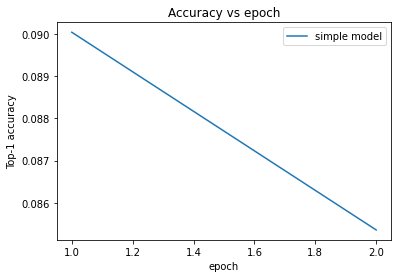

In [19]:
accuracy = fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"][-1]
print(f"Top-1 accuracy: {accuracy:.3f}.")

num_validation_runs = len(
fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"])
epochs = [(x + 1)* 1 for x in range(num_validation_runs)]

plt.plot(epochs, fitted_model.history["val_factorized_top_k/top_1_categorical_accuracy"], label="simple model")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-1 accuracy");
plt.legend();

### Save model

In [113]:
# Save model
query_path = os.path.join('./models/', f"{filename}_package_query_model")
model.user_model.save(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
model.hotel_cluster_model.save(candidate_path)

In [114]:
os.getcwd()

'/Users/wf07pu/Documents/workspace/Kaggle_expedia/deep-learning'

In [29]:
model.user_model(list(cached_test.take(1))[0])

<tf.Tensor: shape=(4096, 32), dtype=float32, numpy=
array([[-0.11536495, -0.35532725, -0.29341123, ..., -0.12003823,
        -0.1506847 ,  0.13403347],
       [-0.06841899,  0.12776509, -0.00734759, ...,  0.16686675,
        -0.39123264, -0.13943402],
       [-0.25987336, -0.0114258 ,  0.34444422, ...,  0.6702015 ,
        -0.53774613, -0.5448187 ],
       ...,
       [-0.18969959, -0.41773486, -0.13887192, ...,  0.1610161 ,
         0.07017141,  0.25148642],
       [-0.3093794 ,  0.13931379, -0.14610325, ...,  1.1008857 ,
         0.11728058, -0.13133314],
       [-0.08509706, -0.39110804, -0.23782617, ..., -0.10203935,
         0.02522854,  0.19742453]], dtype=float32)>

In [121]:
# Load model
filename = 'train_sample'
query_path = os.path.join('./models/', f"{filename}_package_query_model")
user_model = tf.keras.models.load_model(query_path)

candidate_path = os.path.join('./models/', f"{filename}_package_candidate_model")
candidate_model = tf.keras.models.load_model(candidate_path)

## Predictions

In [87]:
df_test = pd.read_csv(data_dir + 'test.csv')
final_test_set = create_tf_test_dataset(df_test)

final_test_set_cached = final_test_set.batch(4096)

In [88]:
user_embeddings = model.user_model.predict(final_test_set_cached)

user_embeddings.shape

ValueError: in user code:

    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1462 predict_function  *
        return step_function(self, iterator)
    <ipython-input-64-a8eb78a96df4>:72 call  *
        self.user_location_city_embedding(inputs["user_location_city"])
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py:1654 concat
        return gen_array_ops.concat_v2(values=values, axis=axis, name=name)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py:1222 concat_v2
        "ConcatV2", values=values, axis=axis, name=name)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/framework/func_graph.py:593 _create_op_internal
        compute_device)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:3485 _create_op_internal
        op_def=op_def)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1975 __init__
        control_input_ops, op_def)
    /Users/wf07pu/miniconda3/envs/recommender/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 2 but is rank 3 for '{{node sequential_36/user_model_5/concat}} = ConcatV2[N=9, T=DT_FLOAT, Tidx=DT_INT32](sequential_36/user_model_5/sequential_37/embedding_31/embedding_lookup/Identity, sequential_36/user_model_5/category_encoding_10/bincount/DenseBincount, sequential_36/user_model_5/normalization_15/truediv, sequential_36/user_model_5/sequential_38/embedding_32/embedding_lookup/Identity_1, sequential_36/user_model_5/category_encoding_11/bincount/DenseBincount, sequential_36/user_model_5/sequential_39/embedding_33/embedding_lookup/Identity_1, sequential_36/user_model_5/sequential_40/embedding_34/embedding_lookup/Identity_1, sequential_36/user_model_5/normalization_17/truediv, sequential_36/user_model_5/sequential_41/embedding_35/embedding_lookup/Identity_1, sequential_36/user_model_5/concat/axis)' with input shapes: [?,32], [?,2], [?,1], [?,1,32], [?,2], [?,1,32], [?,1,32], [?,1], [?,1,32], [].


### Determine k

Note that we determine k on the training set, ideally you want to determine it on the validation set. Not needed for this challenge as the accuracy is not averaged over the number of predictions. Meaning the optimal value is k=5 as providing less recommendations can never improve the metric.

In [73]:
cached_df = dataset.take(500_000).batch(500_000)

In [74]:
user_embeddings_train = model.user_model.predict(cached_df)

In [76]:
index_bruteforce = tfrs.layers.ann.BruteForce()

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

(scores, brute_force_result) = index_bruteforce(queries=user_embeddings_train)

results_train = [[int(i)
 for i 
 in query[:5]]
 for query
 in brute_force_result.numpy()
]

In [101]:
determine_k_df = (
    pd.DataFrame({'hotel_cluster' : df['hotel_cluster'][:500_000], 'predict' : results_train})
     .assign(
        top5=lambda df: df.apply(lambda x: x['hotel_cluster'] in x['predict'], axis=1))
    .assign(
        k=lambda df: df.apply(lambda x: x['predict'].index(x['hotel_cluster']) if x['top5'] else None, axis=1))
)

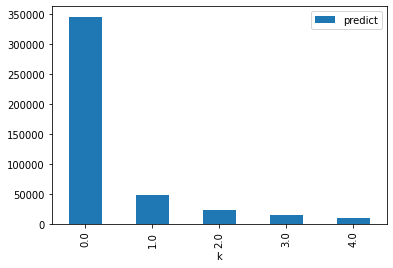

In [116]:
determine_k_df[determine_k_df['top5']].groupby('k').count().plot(kind='bar', y='predict');

In [128]:
def k_accuracy(df, k):
    return len(df[df['k'] <= k]) / (len(df) * (1 + k))

In [134]:
print(f'Accuracy k=1 {k_accuracy(determine_k_df, 0):.3f}')
print(f'Accuracy k=2 {k_accuracy(determine_k_df, 1):.3f}')
print(f'Accuracy k=3 {k_accuracy(determine_k_df, 2):.3f}')
print(f'Accuracy k=4 {k_accuracy(determine_k_df, 3):.3f}')
print(f'Accuracy k=5 {k_accuracy(determine_k_df, 4):.3f}')

Accuracy k=1 0.690
Accuracy k=2 0.394
Accuracy k=3 0.278
Accuracy k=4 0.216
Accuracy k=5 0.177


### Brute Force

In [24]:
# Create a model that takes in raw query features, and
# index_bruteforce = tfrs.layers.factorized_top_k.BruteForce()

index_bruteforce = tfrs.layers.ann.BruteForce()

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

(scores, brute_force_result) = index_bruteforce(queries=user_embeddings)

results = [[str(int(i))
 for i 
 in query[:5]]
 for query
 in brute_force_result.numpy()
]

In [46]:
scores[9].numpy()

array([4.528264 , 3.8475575, 3.3138466, 3.278887 , 3.1990438, 3.1466887,
       3.1171858, 2.771071 , 2.668694 , 2.6567016], dtype=float32)

In [ ]:
pd.DataFrame({'id': df_test['id'], 'hotel_cluster': [' '.join(result) for result in results]}).to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c expedia-hotel-recommendations -f submission.csv -m "First tensorflow-recommender approach"

## Archive

In [ ]:
_, hotel_cluster = index(queries={'user_id':tf.constant(["472333"]), 
                                   'is_package': tf.constant([1])})
print(f"Recommendations for user 472333: {hotel_cluster[0, :3]}")

In [ ]:
users_to_predict

In [ ]:
results = []

for i, user in users_to_predict.iterrows():
    _, hotel_clusters = index(queries={'user_id':tf.constant([str(user['user_id'])]), 
                                       'is_package': tf.constant([user['is_package']])})
    results.append({'user_id': user['user_id'], 'hotel cluster' : [int(i) for i in hotel_clusters[0, :5].numpy()]})
    if i % 1_000 == 0:
        print(f"Parsed {i} users.")

In [ ]:
pd.DataFrame(results)

### Brute force per record

Too slow and yields the same result

In [ ]:
# Create a model that takes in raw query features, and
index_bruteforce = tfrs.layers.ann.BruteForce(query_model=model.user_model)

hotel_cluster_embeddings = hotels.batch(100).map(model.hotel_cluster_model)

# recommends hotels from all hotel clusters.
index_bruteforce.index(candidates=hotel_cluster_embeddings, 
                      identifiers=hotels)

results_bruteforce = []

for row in final_test_set.batch(1).take(5_00):
    _, hotel_cluster = index_bruteforce(queries=row)
    results_bruteforce.append([int(i) for i in hotel_cluster.numpy()[0][:5]])

### Annoy

Uses NNeirest neighbours for the items. Because we 'only' have 100 items (=hotel clusters), the computational benefit does not differ much from brute force.

In [ ]:
from annoy import AnnoyIndex

index = AnnoyIndex(embedding_dimension, "dot")

hotel_embeddings = hotels.enumerate().map(lambda idx, cluster: (idx, cluster, model.hotel_cluster_model(cluster)))
hotel_embeddings

# We unbatch the dataset because Annoy accepts only scalar (id, embedding) pairs.
for hotel_id, _, hotel_embedding in hotel_embeddings.as_numpy_iterator():
    index.add_item(hotel_id, hotel_embedding)

# Build a 10-tree ANN index.
index.build(10)

results = []

for i, row in enumerate(final_test_set.batch(1).take(len(final_test_set))):
    query_embedding = model.user_model(row)[0]
    results.append(index.get_nns_by_vector(query_embedding, 5))
    print(query_embedding)
    if i % 10_000 == 0:
        print(f"Parsed {i} users.")
        
# import pickle

# with open("./results_230_000.txt", "wb") as fp:   #Pickling
#     pickle.dump(results, fp)